# **Assignment 1**

## **Task 1: Corpus**

#### **1.1 Packages**

In [1]:
# downloads and data extraction
import wget
import zipfile
import os
import gensim.downloader as gloader
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tokenization libraries
from collections import OrderedDict
from tqdm import tqdm

# Model-related libraries
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.layers import Masking




In [2]:
# Setting random seeds
random_seed1 = 101
random_seed2 = 102
random_seed3 = 103

#### **1.2 Dataset download**

In [3]:
# URL for downloading the dataset zip file
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_name = 'dependency_treebank'

print(f"Current work directory: {Path.cwd()}")

# Creating a path for the dataset folder
dataset_folder = Path.cwd().joinpath("Datasets")
print(dataset_folder)

# Checking if the dataset folder exists, and creating it if not
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

# Creating paths for the dataset zip file and the dataset itself
dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

# Downloading the dataset zip file if it doesn't exist
if not dataset_zip_path.exists():
    wget.download(url, out=str(dataset_folder))

# Extracting the dataset if it hasn't been extracted
if not dataset_path.exists():
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
print('\n\n')     

# Visualize an example
print('** EXAMPLE **\n')
file_path = dataset_folder.joinpath(dataset_name, dataset_name, 'wsj_0001.dp')
#file_path = dataset_folder.joinpath(dataset_name, 'wsj_0001.dp')
if file_path.is_file():
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)
else:
    print('error in accessing the file')


Current work directory: c:\Users\ricca\Desktop\Università\nlp\assignments\Assignment 1
c:\Users\ricca\Desktop\Università\nlp\assignments\Assignment 1\Datasets



** EXAMPLE **

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



#### **1.3 Dataset encoding**

In [4]:
text_list = []    # to store text data
labels_list = []  # to store labels
doc_list = []     # to store document numbers

folder = dataset_folder.joinpath(dataset_name, dataset_name)
#folder = dataset_folder.joinpath(dataset_name)

# Iterate through each file in the folder with the '.dp' extension
for file_path in folder.glob('*.dp'):
    with open(os.path.join(folder, file_path), 'r') as file:
        # Extracting document number from the file path
        doc_num = int(str(file_path)[-7:-3]) #save doc number
        lines = file.readlines()

        # Extracting text and labels from each line
        text = ' '.join(line.split()[0] if len(line.split()) > 0 else '' for line in lines)
        labels = [line.split()[1] if len(line.split()) > 1 else '' for line in lines]

        text_list.append(text)
        labels_list.append(labels)
        doc_list.append(doc_num)
    

In [5]:
text_list_splitted = []    # to store split text data
doc_num_splitted = []      # to store split document numbers

# Splitting the text_list into chunks based on double spaces
for i in range(len(text_list)):
    chunks = [chunk for chunk in text_list[i].split('  ') if chunk]
    doc = [doc_list[i] for x in range(len(chunks))]
    text_list_splitted.extend(chunks)
    doc_num_splitted.extend(doc)

labels_list_splitted = []

# Splitting the labels_list into chunks based on empty strings
for sublist in labels_list:
    chunks = [[]]
    for item in sublist:
        if item == '':
            if chunks[-1]:
                chunks.append([])
        else:
            chunks[-1].append(item)
    labels_list_splitted.extend(chunks)

# Check dimensions of the split data
print(f"the length of labels is {len(labels_list_splitted)}")
print(f"the length of text is {len(text_list_splitted)}")

# Creating a DataFrame using pandas
df = pd.DataFrame({'text' : text_list_splitted,'labels' : labels_list_splitted, 'doc_num' : doc_num_splitted})
df.head()

the length of labels is 3914
the length of text is 3914


,text,labels,doc_num
0,"Pierre Vinken , 61 years old , will join the b...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"Rudolph Agnew , 55 years old and former chairm...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,A form of asbestos once used to make Kent ciga...,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"The asbestos fiber , crocidolite , is unusuall...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


#### **1.4 Preprocessing**

Since words with capital letters are not present in the GloVe encoding, we trasnform all of them in small letters.

In [6]:
df['text'] = df['text'].str.lower()
df.head()

,text,labels,doc_num
0,"pierre vinken , 61 years old , will join the b...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"mr. vinken is chairman of elsevier n.v. , the ...","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"rudolph agnew , 55 years old and former chairm...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,a form of asbestos once used to make kent ciga...,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"the asbestos fiber , crocidolite , is unusuall...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


#### **1.5 Dataframe splitting and evaluation**

In [7]:
# Splitting the DataFrame into training, validation, and test sets based on document numbers
train = df.loc[df['doc_num']<=100]
validation = df.loc[df['doc_num']>100]
validation = validation.loc[df['doc_num']<151]
test = df.loc[df['doc_num']>150]

# Size check
print(f' size of training set: {train.shape[0]}, \n size of validation set: {validation.shape[0]},\n size of test set: {test.shape[0]}')

 size of training set: 1963, 
 size of validation set: 1299,
 size of test set: 652


In [8]:
#Function to compute the percentage of each label in the DataFrame
def percentage_of_tags(df, name, prt = True):
    # Extract all labels from the 'labels' column in the DataFrame
    labels = [x for y in df['labels'] for x in y]

    # Count the occurrences of each unique label
    uniques = {}
    for i in labels:
        if i in uniques:
            uniques[i] += 1
        else:
            uniques[i] = 1

    # Calculate the total count of labels
    count = sum(uniques.values())

    # Print the percentages if prt is True
    if prt == True:
            uniques_sorted = sorted(uniques.items(), key=lambda x: x[1], reverse = True)
            print(f'Distribution for each tag in {name}:\n')
            print('-'*15)
            for i, j in uniques_sorted:
                percentage = (j / count) * 100
                print(f'{i:<8} | {j} | {percentage:.2f}%')
            print('-'*15)
    
    return 

percentage_of_tags(train, 'train')
percentage_of_tags(validation, 'validation')
percentage_of_tags(test, 'test')

Distribution for each tag in train:

---------------
NN       | 6270 | 13.24%
NNP      | 5202 | 10.98%
IN       | 4952 | 10.46%
DT       | 4076 | 8.61%
NNS      | 3004 | 6.34%
JJ       | 2992 | 6.32%
,        | 2571 | 5.43%
.        | 1959 | 4.14%
VBD      | 1548 | 3.27%
RB       | 1490 | 3.15%
CD       | 1439 | 3.04%
VB       | 1195 | 2.52%
CC       | 1141 | 2.41%
VBZ      | 1133 | 2.39%
VBN      | 1031 | 2.18%
TO       | 1028 | 2.17%
PRP      | 954 | 2.01%
VBG      | 763 | 1.61%
VBP      | 727 | 1.54%
MD       | 413 | 0.87%
PRP$     | 409 | 0.86%
``       | 409 | 0.86%
POS      | 403 | 0.85%
''       | 399 | 0.84%
$        | 342 | 0.72%
:        | 293 | 0.62%
WDT      | 204 | 0.43%
JJR      | 157 | 0.33%
WP       | 141 | 0.30%
RP       | 140 | 0.30%
NNPS     | 95 | 0.20%
JJS      | 93 | 0.20%
WRB      | 92 | 0.19%
RBR      | 86 | 0.18%
-RRB-    | 55 | 0.12%
-LRB-    | 52 | 0.11%
EX       | 49 | 0.10%
RBS      | 19 | 0.04%
LS       | 10 | 0.02%
PDT      | 9 | 0.02%
WP$      | 6 | 0.01

As it emerges from a first look, some tags are extremely under-represented in the the training set.

## **Task 2: Text Encoding**

#### **2.1 GloVe embedding**

In [9]:
def load_glove(embedding_dimension):
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension!")
        raise e
    return emb_model

# Load the GloVe word embedding model
embedding_dimension = 50
embedding_model = load_glove(embedding_dimension)

#### **2.2 Handling OOV**

The pipeline for the OOV managment is:
 - We identify the oov terms (words not present in the GLOVE vocabulary) present in the training, validation and test set
     - For oov terms of validation and test we consider as oov only those that do not belong to the train set.
 - OOV words in validation and test that are not present in the training set are substituted with the special string **[UNK]**

In [10]:
# Save the list of distinct words present in the dataset and the list of words that are present in the dataframe, but are not present in the GloVe vocabulary
def counter(df, embedding_model):
    all_words = []
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in all_words:
                all_words.append(token)
    
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    all_oov = set(all_words).difference(embedding_vocabulary)
    return all_words, all_oov

list_words_df, list_oov_df = counter(df, embedding_model)
print('\nThe number of distinct words and oov words in the dictionary are respectively:', len(list_words_df), 'and', len(list_oov_df))

100%|██████████| 3914/3914 [00:01<00:00, 2155.70it/s]


The number of distinct words and oov words in the dictionary are respectively: 10947 and 676


In [11]:
def oov_counter(df, oov_terms):
        count = 0
        list_oov = []
        for sentence in tqdm(df.text.values):
                tokens = sentence.split()
                for token in tokens:
                        if token in oov_terms and token not in list_oov:
                                count += 1
                                list_oov.append(token)
        return list_oov

train_oov_list = oov_counter(train, list_oov_df)
val_oov_list = oov_counter(validation, list_oov_df)
test_oov_list = oov_counter(test, list_oov_df)

# Remove frome those lists those oov that are present also in train
val_oov_list = [word for word in val_oov_list if word not in train_oov_list]
test_oov_list = [word for word in test_oov_list if word not in train_oov_list]
print(f'\nOOV words in train: {len(train_oov_list)}\nOOV words in val: {len(val_oov_list)}\nOOV words in test: {len(test_oov_list)}')

100%|██████████| 652/652 [00:00<00:00, 320145.89it/s]


OOV words in train: 359
OOV words in val: 189
OOV words in test: 140


Now, following the instructions, we substitute the oov words present in the validation and test with the special string **[UNK]**

In [12]:
def replace_oov_words(df, oov_list):
    new_sentences = []
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        new_tokens = ['[UNK]' if token in oov_list else token for token in tokens]
        new_sentence = ' '.join(new_tokens)
        new_sentences.append(new_sentence)
    return new_sentences

validation['text'] = replace_oov_words(validation, val_oov_list)
test['text'] = replace_oov_words(test, test_oov_list)

100%|██████████| 652/652 [00:00<00:00, 28046.63it/s]


In [13]:
# A quick check shows us that now the [UNK] string substituted the OOV words
test.head()

,text,labels,doc_num
3262,"[UNK] trace inc. , san antonio , texas , said ...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...",151
3263,the move boosts [UNK] chairman asher edelman '...,"[DT, NN, VBZ, NNP, NNP, NNP, NNP, POS, NN, TO,...",151
3264,mr. ackerman already is seeking to oust mr. ed...,"[NNP, NNP, RB, VBZ, VBG, TO, VB, NNP, NNP, IN,...",151
3265,the action followed by one day an [UNK] announ...,"[DT, NN, VBN, IN, CD, NN, DT, NNP, NN, IN, PRP...",151
3266,in new york stock exchange composite trading y...,"[IN, NNP, NNP, NNP, NNP, JJ, NN, NN, ,, NNP, N...",151


#### **2.3 Building the vocabulary**

In [14]:
def build_vocabulary(train, val, test):
    df = pd.concat([train, val, test], ignore_index=True)
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 1 #start from one to leave space for the padding token

    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [15]:
# Sanity check
idx_to_word, word_to_idx, word_listing = build_vocabulary(train, validation, test)
special_token = '[UNK]'

# Debugging information to check vocabulary sizes and sample words
print(f'\n[Debug]  Index -> Word [dataset] vocabulary size: {len(idx_to_word)}')
print(f'[Debug]  Word -> Index [dataset] vocabulary size: {len(word_to_idx)}')
print(f'[Debug]  Some words of [dataset]: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')
print(f'[Debug]  Special string encoding -------> {word_to_idx[special_token]}')

100%|██████████| 3914/3914 [00:00<00:00, 230235.84it/s]


[Debug]  Index -> Word [dataset] vocabulary size: 10631
[Debug]  Word -> Index [dataset] vocabulary size: 10631
[Debug]  Some words of [dataset]: [('pierre', 1), ('vinken', 2), (',', 3), ('61', 4), ('years', 5), ('old', 6), ('will', 7), ('join', 8), ('the', 9), ('board', 10)]
[Debug]  Special string encoding -------> 7405


In [16]:
# We can check the oov words of this vocabulary
def check_OOV_terms(embedding_model, word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)

print(f"Total OOV terms - in the entire dataset: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(f'\n\nSome OOV words from the dataset: {[oov_terms[i] for i in range(10)]}')

Total OOV terms - in the entire dataset: 360 (3.39%)


Some OOV words from the dataset: ['sometimes-exhausting', 'bermuda-based', 'search-and-seizure', 'church-goers', 'hummerstone', 'asset-sale', 'prize-fighter', 'stock-manipulation', '38.375', 'student-test']


**NB. The number of oov (360) is coherent with what we did until now. In fact we had 359 oov words from the training set and to those we added one (the one corresponding to [UNK])**

<br>
<br>
<br>

#### **2.4 Building the embedding matrix**
Now we have to handle the oov words coming from the training set. Since many of the oov words are composed words: 
 - if the oov is a composed word: 
      - If both the words that compose it are present in the vocabulary, the assigned embedding is the average of the two
      - If just one of the two words is known, the assigned vector is the average between the known word and a random vector
 - if the oov is not composed it is assigned a random vector


In [17]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            # Handle cases where the word is not present in the embedding model
            if '-' in word:
                subwords = word.split('-')
                subword_embeddings = []

                for subword in subwords:
                    try:
                        subword_embedding = embedding_model[subword]
                        subword_embeddings.append(subword_embedding)
                    except KeyError:
                        # Use a random embedding if the subword is not present in the model
                        subword_embeddings.append(np.random.uniform(low=-0.5, high=0.5, size=embedding_dimension))

                if subword_embeddings:
                    embedding_vector = np.mean(subword_embeddings, axis=0)
                else:
                    # Use a random embedding if no subwords are present
                    embedding_vector = np.random.uniform(low=-0.5, high=0.5, size=embedding_dimension)
            else:
                # Use a random embedding if the word is not present and not a compound word
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

#### **2.5 Obtaining the Embedding Matrix**

In [18]:
# Setting the right dimensions for the weight matrix
embedding_shape = len(word_listing) + 1 # +1 for the padding token

In [19]:
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, embedding_shape)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 10631/10631 [00:00<00:00, 342029.07it/s]

Embedding matrix shape: (10632, 50)


## **Task 3: Model Definition**

#### **3.1 Creation of X and y and their encoding**

In [20]:
# split in X and y
def df_splitting(df):
    X = df[['text']]
    y = df[['labels']]
    return X, y

Xtrain, ytrain = df_splitting(train)
Xval, yval = df_splitting(validation)
Xtest, ytest = df_splitting(test)

In [21]:
# Extract a list of lists from text
def to_list(X, y):
    sentences = []
    tags = []
    for sentence in tqdm(X.text.values):
        tokens = sentence.split()
        sentences.append(tokens)
    
    for tag in tqdm(y.labels.values):
        tags.append(tag)

    return sentences, tags

Xtrain, ytrain = to_list(Xtrain, ytrain)
Xval, yval = to_list(Xval, yval)
Xtest, ytest = to_list(Xtest, ytest)
print('\n', Xtrain[0])

100%|██████████| 652/652 [00:00<?, ?it/s]


 ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']


In [22]:
# Tokenize text 
def tokenize_text(text, word_to_idx):
    def tokenize_subtext(subtext):
        return [word_to_idx[word] for word in subtext if word in word_to_idx]

    tokenized_text = [tokenize_subtext(subtext) for subtext in text]

    return tokenized_text

Xtrain_encoded = tokenize_text(Xtrain, word_to_idx)
Xval_encoded = tokenize_text(Xval, word_to_idx)
Xtest_encoded = tokenize_text(Xtest, word_to_idx)

print('SHOW THE FIRST ENCODED SEQUENCE:\n', Xtrain_encoded[0])

SHOW THE FIRST ENCODED SEQUENCE:
 [1, 2, 3, 4, 5, 6, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [23]:
# Tokenize labels
def tokenize_labels(df, y):
    all_tags = []
    
    for tag in tqdm(df.labels.values):
        all_tags.append(tag)

    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(all_tags)
    
    y_encoded = tag_tokenizer.texts_to_sequences(y)

    # Return the encoded input sentences, encoded labels, and the tag tokenizer
    return y_encoded, tag_tokenizer

ytrain_encoded, tag_to_idx = tokenize_labels(df, ytrain)
yval_encoded, tag_to_idx = tokenize_labels(df, yval)
ytest_encoded, tag_to_idx = tokenize_labels(df, ytest)


print('\nSHOW FIRST ENCODED SEQUENCE:\n', ytrain_encoded[0])
print('\n\nTag_to_idx\n', tag_to_idx.index_word)

100%|██████████| 3914/3914 [00:00<00:00, 3917085.63it/s]


SHOW FIRST ENCODED SEQUENCE:
 [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]


Tag_to_idx
 {1: 'nn', 2: 'in', 3: 'nnp', 4: 'dt', 5: 'nns', 6: 'jj', 7: ',', 8: '.', 9: 'cd', 10: 'vbd', 11: 'rb', 12: 'vb', 13: 'cc', 14: 'to', 15: 'vbn', 16: 'vbz', 17: 'prp', 18: 'vbg', 19: 'vbp', 20: 'md', 21: 'pos', 22: 'prp$', 23: '$', 24: '``', 25: "''", 26: ':', 27: 'wdt', 28: 'jjr', 29: 'nnps', 30: 'wp', 31: 'rp', 32: 'jjs', 33: 'wrb', 34: 'rbr', 35: '-rrb-', 36: '-lrb-', 37: 'ex', 38: 'rbs', 39: 'pdt', 40: '#', 41: 'wp$', 42: 'ls', 43: 'fw', 44: 'uh', 45: 'sym'}


In [24]:
# Recap
print('Xtrain[0]: ', Xtrain[0], '\n')
print('y[0]: ', ytrain[0], '\n')
print()
print('X[0]: ', Xtrain_encoded[0], '\n')
print('y[0]: ', ytrain_encoded[0], '\n')

# Length check
different_length_train = [1 if len(input) != len(output) else 0 for input, output in zip(Xtrain_encoded, ytrain_encoded)]
different_length_val = [1 if len(input) != len(output) else 0 for input, output in zip(Xval_encoded, yval_encoded)]
different_length_test = [1 if len(input) != len(output) else 0 for input, output in zip(Xtest_encoded, ytest_encoded)]

print(f'{sum(different_length_train)} sentences have disparate input-output lengths in the train set.')
print(f'{sum(different_length_val)} sentences have disparate input-output lengths in the validation set.')
print(f'{sum(different_length_test)} sentences have disparate input-output lengths in the test set.')

if (sum(different_length_train) and sum(different_length_val) and sum(different_length_test))==0:
    print('\nEverything is ok!!')
else:
    print(f'There are {sum(different_length_train) + sum(different_length_val) + sum(different_length_test)} sequences with different length in the train.')

Xtrain[0]:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.'] 

y[0]:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 


X[0]:  [1, 2, 3, 4, 5, 6, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] 

y[0]:  [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8] 

0 sentences have disparate input-output lengths in the train set.
0 sentences have disparate input-output lengths in the validation set.
0 sentences have disparate input-output lengths in the test set.

Everything is ok!!


In [25]:
num_words = len(word_to_idx)
num_tags = len(tag_to_idx.index_word)
print(f'\nnumber of words: {num_words}\nnumber of tags: {num_tags}')


number of words: 10631
number of tags: 45


#### **3.2 Padding and truncating**

Length of longest sentence:  249 




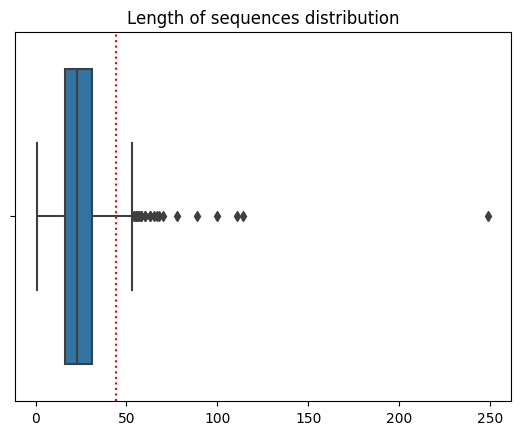

In [26]:
import seaborn as sns

# Check which is the longest sequence of our training set
lengths = [len(seq) for seq in Xtrain_encoded]
print('Length of longest sentence: ', max(lengths), '\n\n')

# Check the distribution of the length of the sequences
sns.boxplot(lengths)
percentile_95 = np.percentile(lengths, 95)
plt.axvline(x=percentile_95, color='red', linestyle='dotted', label='95th Percentile')
plt.title('Length of sequences distribution')
plt.show();

MAX_SEQ_LENGTH = 50

In [27]:
def pad_and_truncate(list_tokenized, max_length=MAX_SEQ_LENGTH, padding_value=0):
    # Pad and truncate each sublist in the list_tokenized
    list_padded = [[padding_value] * (max_length - len(seq)) + seq[:max_length] for seq in list_tokenized]

    return list_padded

Xtrain_padded = pad_and_truncate(Xtrain_encoded)
Xval_padded = pad_and_truncate(Xval_encoded)
Xtest_padded = pad_and_truncate(Xtest_encoded)

ytrain_padded = pad_and_truncate(ytrain_encoded)
yval_padded = pad_and_truncate(yval_encoded)
ytest_padded = pad_and_truncate(ytest_encoded)

# everything as numpy arrays
Xtrain_padded = np.array(Xtrain_padded)
Xval_padded = np.array(Xval_padded)
Xtest_padded = np.array(Xtest_padded)

print(f'{Xtrain_padded[0]}\n\n{ytrain_padded[0]}')

# and to one-hot encoded format
ytrain_padded = to_categorical(ytrain_padded, num_classes=num_tags+1)
yval_padded = to_categorical(yval_padded, num_classes=num_tags+1)
ytest_padded = to_categorical(ytest_padded, num_classes=num_tags+1)

print(f'{Xtrain_padded[0]}\n\n{ytrain_padded[0]}')


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  2  3  4  5  6  3  7  8  9 10 11 12 13 14 15
 16 17]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  2  3  4  5  6  3  7  8  9 10 11 12 13 14 15
 16 17]

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
# Check on the dimensions
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(Xtrain_padded.shape))
print('Shape of output sequences: {}'.format(ytrain_padded.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(Xval_padded.shape))
print('Shape of output sequences: {}'.format(yval_padded.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(Xtest_padded.shape))
print('Shape of output sequences: {}'.format(ytest_padded.shape))

TRAINING DATA
Shape of input sequences: (1963, 50)
Shape of output sequences: (1963, 50, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1299, 50)
Shape of output sequences: (1299, 50, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (652, 50)
Shape of output sequences: (652, 50, 46)


#### **3.4 Models Definition**

In [29]:
# Useful variables
NUM_CLASSES = num_tags + 1 # consider also the padding token
VOCABULARY_SIZE = embedding_shape
Mask_el = 0

# Training parameters
num_epochs = 24
batch_size = 32

<br>
<br>

**Baseline Model**

In [30]:
from keras import metrics
def baseline(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    # Set random seeds for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential(name=name)

    # Embedding layer with pre-trained weights
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    
    # Masking layer to handle padding
    model.add(Masking(mask_value=Mask_el))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # TimeDistributed layer with softmax activation for multi-class classification
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.Precision()])

    model.summary()

    return model

<br>
<br>

**Model 1**

In [31]:
def model_1(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    # Set random seeds for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential(name=name)

    # Embedding layer with pre-trained weights
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    
    # Masking layer to handle padding
    model.add(Masking(mask_value=Mask_el))

    # Bidirectional LSTM layer for sequence processing
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Additional LSTM layer as requested
    model.add(LSTM(128, return_sequences=True))

    # TimeDistributed layer with softmax activation for multi-class classification
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    # Compile the model with categorical crossentropy loss and custom F1 score metric
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.Precision()])

    model.summary()

    return model

<br>
<br>

**Model 2**

In [32]:
def model_2(Mask_el, embedding_dimension, seed, embedding_matrix, name):
    # Set random seeds for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential(name=name)

    # Embedding layer with pre-trained weights
    model.add(Embedding(input_dim=VOCABULARY_SIZE,
                        output_dim=embedding_dimension,
                        input_length=MAX_SEQ_LENGTH,
                        weights=[embedding_matrix],
                        trainable=True))
    
    # Masking layer to handle padding
    model.add(Masking(mask_value=Mask_el))

    # Bidirectional LSTM layer for sequence processing
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Additional Dense layer
    model.add(TimeDistributed(Dense(128, activation='relu')))

    # TimeDistributed layer with softmax activation for multi-class classification
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    # Compile the model with categorical crossentropy loss and custom F1 score metric
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.Precision()])

    model.summary()

    return model

In [33]:
# Definition of the three baselines models with different random seeds
baseline_1 = baseline(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'Baseline_1')
baseline_2 = baseline(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'Baseline_2')
baseline_3 = baseline(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'Baseline_3')


Model: "Baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            531600    
                                                                 
 masking (Masking)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           183296    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 46)            11822     
 ributed)                                                        
                                                                 
Total params: 726718 (2.77 MB)
Trainable params: 726718 (2.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Baseline_2"


In [34]:
# Definition of the three model 1 with different random seeds
model_1_1 = model_1(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'MODEL1_seed1')
model_1_2 = model_1(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'MODEL1_seed2')
model_1_3 = model_1(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'MODEL1_seed3')

Model: "MODEL1_seed1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            531600    
                                                                 
 masking_3 (Masking)         (None, 50, 50)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 256)           183296    
 onal)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           197120    
                                                                 
 time_distributed_3 (TimeDi  (None, 50, 46)            5934      
 stributed)                                                      
                                                                 
Total params: 917950 (3.50 MB)
Trainable params: 91795

In [35]:
# Definition of the three model 2 with different random seeds
model_2_1 = model_2(Mask_el, embedding_dimension, random_seed1, embedding_matrix, 'MODEL2_seed1')
model_2_2 = model_2(Mask_el, embedding_dimension, random_seed2, embedding_matrix, 'MODEL2_seed2')
model_2_3 = model_2(Mask_el, embedding_dimension, random_seed3, embedding_matrix, 'MODEL2_seed3')

Model: "MODEL2_seed1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 50)            531600    
                                                                 
 masking_6 (Masking)         (None, 50, 50)            0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 256)           183296    
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (None, 50, 128)           32896     
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 50, 46)            5934      
 stributed)                                                      
                                                      

In [36]:
# Save the three kinds of models with their three seeds in three lists, for next steps
bases = [baseline_1, baseline_2, baseline_3]
models1 =[model_1_1, model_1_2, model_1_3]
models2 = [model_2_1, model_2_2, model_2_3]

<br>
<br>

## **TASK 4 - METRICS** 

**N.B: Evaluation and computation of tp, fp, fn:**

**- True Positive (TP):** This occurs when the model correctly predicts a positive (i.e., the correct POS tag) instance. For example, if the true POS tag is "NN" (noun) and the model predicts "NN," it's a true positive for the "NN" class.

**- False Positive (FP):** This happens when the model incorrectly predicts a positive instance. For example, if the true POS tag is "NN" (noun) but the model predicts "VB" (verb), it's a false positive for the "VB" class.

**- False Negative (FN):** This occurs when the model fails to predict a positive instance that should have been predicted. For instance, if the true POS tag is "NN" (noun) but the model predicts "O" (other), it's a false negative for the "NN" class.

<br>
<br>

#### **4.1 Handling the punctuation tokens, that DO NOT have to be considered**

Save the tokens corresponding to english punctuation, since they have to be ignored at evaluation time

In [37]:
word_to_token = tag_to_idx.word_index

english_punctuation = [',', '.', '``', '\'\'', ':', '-rrb-', '-lrb-']
punctuation_tokens = [token for word, token in word_to_token.items() if word in english_punctuation]
print('Punctuation tokens:\n', punctuation_tokens)

Punctuation tokens:
 [7, 8, 24, 25, 26, 35, 36]


<br>
<br>

#### **4.2 Define the functions to compute the required metric (excluding the punctuation tokens)**

Define a function to accumulate tp, fp, fn for each class, iterating on all tokens. This function computes the true positive, false positives and false negatives given a series of predictions and the true labels. In order to not have punctuation tokens influence our evaluation, the count of FP and FN won't be considered if the missed prediction regards in some way a punctuation token. For example, if a ',' is classified as 'nn' the 'nn' won't have a +1 in FP in this case. At the same way if a 'nn' is misclassified and is considered as ',', it will not cause a +1 in FN for 'nn'.

In [38]:
def tp_computation(ytrue, ypred, num_classes, punctuation_tokens):
    tp = [0] * num_classes
    fp = [0] * num_classes
    fn = [0] * num_classes

    for true_labels, pred_labels in zip(ytrue, ypred):
        for true_label, pred_label in zip(true_labels, pred_labels):
            if true_label == pred_label:
                tp[true_label] += 1
            elif true_label != 0 and true_label not in punctuation_tokens and pred_label not in punctuation_tokens:
                fp[pred_label] += 1
                fn[true_label] += 1

    return tp, fp, fn

# Compute the predictions 
def compute_predictions(model, X):
    ypred = model.predict(X, batch_size=batch_size)
    ypred_max = np.argmax(ypred, axis=-1)
    return ypred_max

# Create confusion matrix
def create_confusion_matrix(tp, fp, fn, tokens_to_avoid): 
    tp_fil = [element for index, element in enumerate(tp) if index not in tokens_to_avoid]
    fp_fil = [element for index, element in enumerate(fp) if index not in tokens_to_avoid]
    fn_fil = [element for index, element in enumerate(fn) if index not in tokens_to_avoid]
    
    tokens = [value for key, value in tag_to_idx.index_word.items() if key not in tokens_to_avoid]
    
    totals = []
    macros = []
    for i in range(len(tp_fil)):
        total = tp_fil[i] + fn_fil[i]
        totals.append(total)
        precision = tp_fil[i] / (tp_fil[i] + fp_fil[i] + K.epsilon())
        recall = tp_fil[i] / (tp_fil[i] + fn_fil[i] + K.epsilon())
        f1_i = round(2 * (precision * recall) / (precision + recall + K.epsilon()), 2)
        macros.append(f1_i)
    data = {
        'tokens' : tokens,
        'total_occurences' : totals,
        'TP' : tp_fil,
        'FP' : fp_fil,
        'FN' : fn_fil,
        'f1-score' : macros
    }
    confusion_matrix_df = pd.DataFrame(data)
    return confusion_matrix_df

# Calculate macro (and weighted) F1 scores
def macro_f1_score(confusion_matrix):
    f1_scores = []
    weights = []
    for item, row in confusion_matrix.iterrows():
        if(row['TP'] + row['FN']) != 0:
            precision = row['TP'] / (row['TP'] + row['FP'] + 1e-10)
            recall = row['TP'] / (row['TP'] + row['FN'] + 1e-10)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            f1_scores.append(f1)

            weight = row['TP'] + row['FN']
            weights.append(weight)
    
    macro_f1 = sum(f1_scores) / len(f1_scores)
    weighted_f1 = sum(w * f for w, f in zip(weights, f1_scores)) / sum(weights)
    return round(macro_f1, 3), round(weighted_f1, 3)

<br>
<br>

## **TASK 5: Training and Evaluation**

#### **5.1 Training all models**

In [39]:
def training(list_of_models, batch_size, num_epochs):
    histories = []

    for model in list_of_models:
        model_fitted = model.fit(Xtrain_padded, ytrain_padded, batch_size=batch_size, epochs=num_epochs, validation_data=(Xval_padded, yval_padded))
        histories.append(model_fitted)
    return histories


<br>
<br>

**Baseline training**

In [40]:
histories_baseline = training(bases, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/24


62/62 [==============================] - 13s 107ms/step - loss: 2.5928 - precision: 0.8888 - val_loss: 1.8759 - val_precision: 0.9247
Epoch 2/24
62/62 [==============================] - 4s 68ms/step - loss: 1.3321 - precision: 0.9229 - val_loss: 0.9996 - val_precision: 0.9279
Epoch 3/24
62/62 [==============================] - 4s 65ms/step - loss: 0.7505 - precision: 0.9311 - val_loss: 0.6724 - val_precision: 0.9222
Epoch 4/24
62/62 [==============================] - 4s 65ms/step - loss: 0.5140 - precision: 0.9392 - val_loss: 0.5293 - val_precision: 0.9249
Epoch 5/24
62/62 [==============================] - 4s 65ms/step - loss: 0.3879 - precision: 0.9494 - val_loss: 0.4467 - val_precision: 0.9264
Epoch 6/24
62/62 [==============================] - 4s 65ms/step - loss: 0.3082 - precision: 0.9547 - val_loss: 0.3959 - val_precision: 0.9305
Epoch 7/24
62/62 [==============================] - 4s 66ms/step - loss: 0.2518 - precision: 0.9621 - val_loss: 0.3630 - val_precision: 0.9304
Epoch 8/

<br>
<br>

**Model 1 training**

In [41]:
histories_model_1 = training(models1, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/24


62/62 [==============================] - 19s 157ms/step - loss: 2.8347 - precision_3: 0.8470 - val_loss: 2.3770 - val_precision_3: 0.8611
Epoch 2/24
62/62 [==============================] - 7s 108ms/step - loss: 1.7462 - precision_3: 0.8927 - val_loss: 1.3005 - val_precision_3: 0.9000
Epoch 3/24
62/62 [==============================] - 7s 111ms/step - loss: 0.9786 - precision_3: 0.9183 - val_loss: 0.8336 - val_precision_3: 0.9224
Epoch 4/24
62/62 [==============================] - 7s 109ms/step - loss: 0.6391 - precision_3: 0.9342 - val_loss: 0.6235 - val_precision_3: 0.9265
Epoch 5/24
62/62 [==============================] - 7s 111ms/step - loss: 0.4641 - precision_3: 0.9456 - val_loss: 0.5118 - val_precision_3: 0.9263
Epoch 6/24
62/62 [==============================] - 7s 111ms/step - loss: 0.3605 - precision_3: 0.9521 - val_loss: 0.4460 - val_precision_3: 0.9310
Epoch 7/24
62/62 [==============================] - 7s 111ms/step - loss: 0.2924 - precision_3: 0.9598 - val_loss: 0.4049 

<br>
<br>

**Model 2 training**

In [42]:
histories_model_2 = training(models2, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/24


62/62 [==============================] - 13s 106ms/step - loss: 2.5608 - precision_6: 0.8782 - val_loss: 1.6449 - val_precision_6: 0.9084
Epoch 2/24
62/62 [==============================] - 4s 67ms/step - loss: 1.0678 - precision_6: 0.9016 - val_loss: 0.7878 - val_precision_6: 0.9005
Epoch 3/24
62/62 [==============================] - 4s 67ms/step - loss: 0.5900 - precision_6: 0.9178 - val_loss: 0.5620 - val_precision_6: 0.9122
Epoch 4/24
62/62 [==============================] - 4s 72ms/step - loss: 0.4195 - precision_6: 0.9311 - val_loss: 0.4680 - val_precision_6: 0.9184
Epoch 5/24
62/62 [==============================] - 5s 74ms/step - loss: 0.3227 - precision_6: 0.9449 - val_loss: 0.4068 - val_precision_6: 0.9193
Epoch 6/24
62/62 [==============================] - 5s 74ms/step - loss: 0.2563 - precision_6: 0.9529 - val_loss: 0.3822 - val_precision_6: 0.9211
Epoch 7/24
62/62 [==============================] - 4s 72ms/step - loss: 0.2088 - precision_6: 0.9620 - val_loss: 0.3500 - val_

<br>
<br>

#### **5.2 Compute the confusion matrices and the macro f1 score for all the seeds of all the models**

In [43]:
# Just for simplicity, include also the 0 (padding token) among the tokens we do not want to consider
punctuation_tokens = [0] + punctuation_tokens

The next function computes the confusion matrix for a given model.

In [44]:
def cm_printing(X, y, list_of_models):
    ytrue_max = np.argmax(y, axis=-1)
    scores = []
    cms = []

    for model in list_of_models:
        # Compute predictions using the model
        ypred = compute_predictions(model, X)

        # Compute true positives, false positives, and false negatives
        tp, fp, fn = tp_computation(ytrue_max, ypred, NUM_CLASSES, punctuation_tokens)
        
        # Create a confusion matrix
        cm = create_confusion_matrix(tp, fp, fn, punctuation_tokens)
        print(cm)
        cms.append(cm)

        # Calculate macro and weighted F1-scores
        macro, weighted = macro_f1_score(cm)
        print(f'F1 - score of {model.name}: ', macro, f'\nWeighted F1 - score of {model.name}: ', weighted)
        scores.append(macro)
    
    return scores, cms

<br>
<br>

**Baseline**

In [45]:
baseline_scores, baseline_cms = cm_printing(Xval_padded, yval_padded, bases)

41/41 [==============================] - 3s 15ms/step
   tokens  total_occurences    TP   FP   FN  f1-score
0      nn              4471  3919  543  552      0.88
1      in              3249  3140   56  109      0.97
2     nnp              2680  2283  358  397      0.86
3      dt              2725  2711   33   14      0.99
4     nns              2089  1862  180  227      0.90
5      jj              1907  1632  550  275      0.80
6      cd              1237  1167   55   70      0.95
7     vbd               854   747   83  107      0.89
8      rb               948   853  156   95      0.87
9      vb               950   857   74   93      0.91
10     cc               750   742    7    8      0.99
11     to               759   759    0    0      1.00
12    vbn               725   581  124  144      0.81
13    vbz               710   642   37   68      0.92
14    prp               566   562    2    4      0.99
15    vbg               472   366  125  106      0.76
16    vbp               458 

<br>
<br>

**Model 1**

In [46]:
model1_scores, model1_cms = cm_printing(Xval_padded, yval_padded, models1)

41/41 [==============================] - 4s 26ms/step
   tokens  total_occurences    TP   FP   FN  f1-score
0      nn              4471  3944  582  527      0.88
1      in              3248  3165   47   83      0.98
2     nnp              2683  2313  469  370      0.85
3      dt              2725  2715   37   10      0.99
4     nns              2087  1863  195  224      0.90
5      jj              1909  1572  480  337      0.79
6      cd              1234  1150   51   84      0.94
7     vbd               854   754  105  100      0.88
8      rb               948   852  116   96      0.89
9      vb               951   854   69   97      0.91
10     cc               750   741    3    9      0.99
11     to               759   759    0    0      1.00
12    vbn               725   581  120  144      0.81
13    vbz               710   631   45   79      0.91
14    prp               566   562    3    4      0.99
15    vbg               471   347  104  124      0.75
16    vbp               458 

<br>
<br>

**Model 2**

In [47]:
model2_scores, model2_cms = cm_printing(Xval_padded, yval_padded, models2)

41/41 [==============================] - 3s 15ms/step
   tokens  total_occurences    TP   FP   FN  f1-score
0      nn              4465  3890  630  575      0.87
1      in              3249  3125   69  124      0.97
2     nnp              2682  2282  396  400      0.85
3      dt              2725  2700   38   25      0.99
4     nns              2087  1840  201  247      0.89
5      jj              1910  1563  488  347      0.79
6      cd              1237  1164   60   73      0.95
7     vbd               854   756  105   98      0.88
8      rb               948   846  150  102      0.87
9      vb               951   835   89  116      0.89
10     cc               750   740    5   10      0.99
11     to               759   758    1    1      1.00
12    vbn               725   562  119  163      0.80
13    vbz               710   641   60   69      0.91
14    prp               566   562    5    4      0.99
15    vbg               472   360  142  112      0.74
16    vbp               458 

<br>
<br>

#### **5.3 Select the better model**

This function compare the trend of models during training

In [48]:
def compare_model_performance(history1, history2, history3, metric='precision'):
    """
    Compare the performance of two models using training history.
    
    Parameters:
        - history1: History object of the baseline model.
        - history2: History object of the first model.
        - history3: History object of the second model.
        - metric: The metric to compare (e.g., 'f1_score', 'accuracy').
    """

    # Create a single subplot
    plt.figure(figsize=(8, 4))

    # Plot training loss for Model baseline, Model 1, and Model 2
    plt.plot(history1.history['loss'], label='Model baseline Training')
    plt.plot(history2.history['loss'], label='Model 1 Training')
    plt.plot(history3.history['loss'], label='Model 2 Training')

    # Set plot title, labels, and legend
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

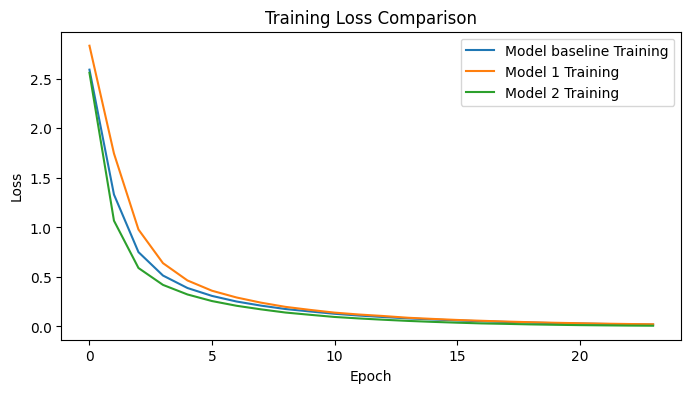

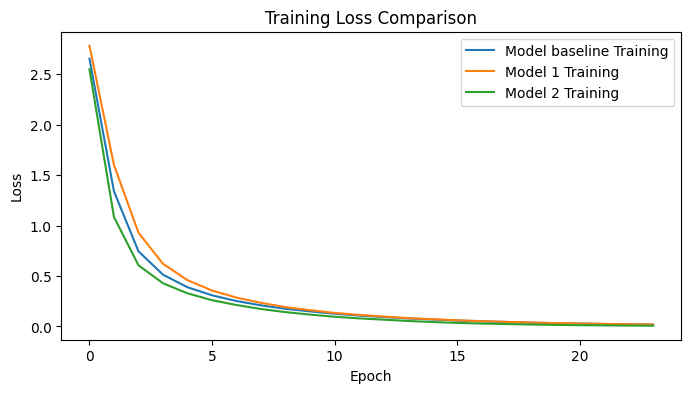

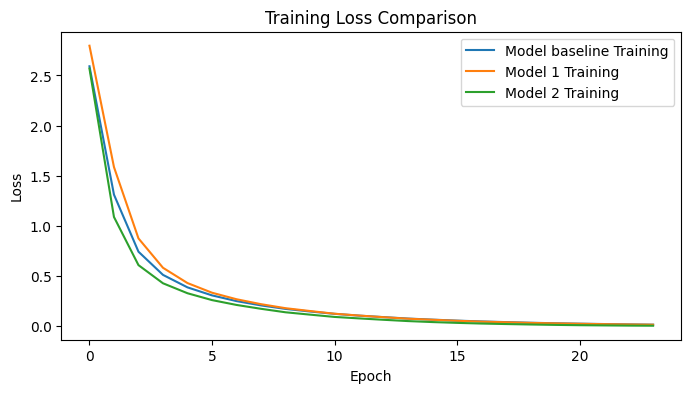

In [49]:
# Compare first seeds
compare_model_performance(histories_baseline[0], histories_model_1[0], histories_model_2[0], metric='Precision()')

# Compare second seeds
compare_model_performance(histories_baseline[1], histories_model_1[1], histories_model_2[1], metric='Precision()')

# Compare third seeds
compare_model_performance(histories_baseline[2], histories_model_1[2], histories_model_2[2], metric='Precision()')



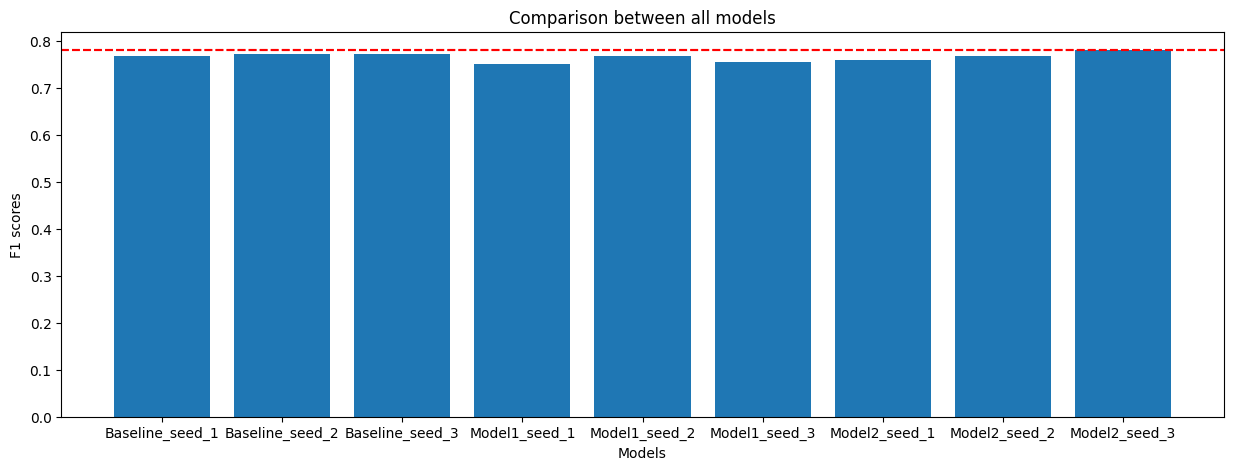

In [50]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
scores = baseline_scores + model1_scores + model2_scores
positions = range(1, 10)

# Names of the models
model_names = ['Baseline_seed_1', 'Baseline_seed_2', 'Baseline_seed_3', 'Model1_seed_1', 'Model1_seed_2', 'Model1_seed_3', 'Model2_seed_1', 'Model2_seed_2', 'Model2_seed_3']
max_value = max(scores)
plt.axhline(y=max_value, color='red', linestyle='--', label='Max Value')

plt.bar(positions, scores)
plt.axhline(y=max_value, color='red', linestyle='--', label='Best Model')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Comparison between all models')
plt.xticks(positions, model_names)
plt.show()


In [51]:
# Compute the average f1 score over the three seeds for the models and the standard deviation

import math

def average_score(score_list):
    count = 0
    for score in score_list:
        count += score
    return count/3

def standard_deviation(score_list):
    mean = sum(score_list) / len(score_list)
    squared_diff = [(score - mean) ** 2 for score in score_list]
    variance = sum(squared_diff) / len(score_list)
    std_dev = math.sqrt(variance)

    return std_dev

# Calculate average scores and standard deviation
average_score_baseline = average_score(baseline_scores)
average_score_model1 = average_score(model1_scores)
average_score_model2 = average_score(model2_scores)
std_dev_baseline = standard_deviation(baseline_scores)
std_dev_model1 = standard_deviation(model1_scores)
std_dev_model2 = standard_deviation(model2_scores)

print('Average score of Baseline Model: ', round(average_score_baseline, 3))
print('Average score of Model 1: ', round(average_score_model1, 3))
print('Average score of Model 2: ', round(average_score_model2, 3))
print('\n\nStandard Deviation of Baseline Model: ', round(std_dev_baseline, 3))
print('Standard Deviation of Model 1: ', round(std_dev_model1, 3))
print('Standard Deviation of Model 2: ', round(std_dev_model2, 3))

Average score of Baseline Model:  0.77
Average score of Model 1:  0.757
Average score of Model 2:  0.769


Standard Deviation of Baseline Model:  0.002
Standard Deviation of Model 1:  0.006
Standard Deviation of Model 2:  0.009


The best model is the **Model 2 with the first seed**.

In [70]:
# Save here the best model and its confusion matrix
best_model = models2[2]
best_score = model2_scores[2]
best_cm = model2_cms[2]

<br>
<br>

## **TASK 6: Error analysis**

#### **6.1 Compare errors made on validation and test set**

In [71]:
# Confront two confusion matrices
def cm_compare(cms1, cms2):
    comparison_cm = {
        'tokens' : cms1['tokens'],
        'f1-score validation' : cms1['f1-score'],
        'f1-score test' : cms2['f1-score'] 
    }
    comparison_cm = pd.DataFrame(comparison_cm)
    print(comparison_cm)
    return comparison_cm

def cm_printing(X, y, model):
    ytrue_max = np.argmax(y, axis=-1)
    ypred = compute_predictions(model, X)
    tp, fp, fn = tp_computation(ytrue_max, ypred, NUM_CLASSES, punctuation_tokens)
    
    cm = create_confusion_matrix(tp, fp, fn, punctuation_tokens)
    print(cm)
    macro, weighted = macro_f1_score(cm)
    print(f'F1 - score of {model.name}: ', macro, f'\nWeighted F1 - score of {model.name}: ', weighted)
    return macro, cm

# Plot the difference in macro f1 score between validation and test set tag-per-tag
def plot_results(cm):
    val_values = cm['f1-score validation']
    test_values = cm['f1-score test']
    xvalues = cm['tokens']
    
    plt.figure(figsize=(12, 6))
    plt.plot(xvalues, val_values, label='Validation results')
    plt.plot(xvalues, test_values, label='Test results')

    plt.xlabel('tokens')
    plt.ylabel('f1 score')
    plt.title('f1 score token by token on validation and test set')
    plt.legend()
    plt.show()
    return 

# Create an heatmap
def heatmap(model, X, y, title):
    ypred = compute_predictions(model, X)
    ytrue = np.argmax(y, axis=-1).flatten()
    string_punctuation_tokens = [str(item) for item in punctuation_tokens]
    index = [value for key, value in tag_to_idx.index_word.items() if key not in punctuation_tokens]
    columns = [str(label) for label in range(NUM_CLASSES)]
    rows = [str(label) for label in range(NUM_CLASSES)]
    df = pd.DataFrame(np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int), columns=columns, index=rows)
    
    for true_label, pred_label in zip(ytrue, ypred.flatten()):
        if true_label != pred_label:
            df.at[str(true_label), str(pred_label)] += 1 # Increment false positives
        else:
            df.at[str(true_label), str(pred_label)] += 1 # Increment true positives
    
    df = df.drop(columns=df.columns.intersection(string_punctuation_tokens),
             index=df.index.intersection(string_punctuation_tokens))
    df.columns = index
    df.index = index

    plt.figure(figsize=(20, 15))
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted Tag')
    plt.ylabel('True Tag')
    plt.show()
    return df


In [72]:
# Confusion matrix and macro f1 score of the best performing model on the test set
test_score, test_cm = cm_printing(Xtest_padded, ytest_padded, best_model)

21/21 [==============================] - 0s 16ms/step
   tokens  total_occurences    TP   FP   FN  f1-score
0      nn              2377  2057  240  320      0.88
1      in              1629  1572   24   57      0.97
2     nnp              1495  1279  217  216      0.86
3      dt              1335  1325   15   10      0.99
4     nns               941   851  103   90      0.90
5      jj               916   759  228  157      0.80
6      cd               858   819   35   39      0.96
7     vbd               634   568   46   66      0.91
8      rb               381   343   73   38      0.86
9      vb               402   382   32   20      0.94
10     cc               364   364    5    0      0.99
11     to               385   385    1    0      1.00
12    vbn               364   277   75   87      0.77
13    vbz               280   259   39   21      0.90
14    prp               192   191    2    1      0.99
15    vbg               221   176   57   45      0.78
16    vbp               134 

In [73]:
# See in detail the difference in the errors tag-per-tag between validation and test set
comparison_cm = cm_compare(best_cm, test_cm)

print('\n\nF1 validation score: ', best_score)
print('\nF1 test score: ', test_score)

   tokens  f1-score validation  f1-score test
0      nn                 0.87           0.88
1      in                 0.97           0.97
2     nnp                 0.85           0.86
3      dt                 0.99           0.99
4     nns                 0.89           0.90
5      jj                 0.79           0.80
6      cd                 0.94           0.96
7     vbd                 0.89           0.91
8      rb                 0.87           0.86
9      vb                 0.89           0.94
10     cc                 0.98           0.99
11     to                 1.00           1.00
12    vbn                 0.79           0.77
13    vbz                 0.90           0.90
14    prp                 0.99           0.99
15    vbg                 0.75           0.78
16    vbp                 0.83           0.87
17     md                 0.99           0.99
18    pos                 0.99           0.99
19   prp$                 1.00           1.00
20      $                 0.99    

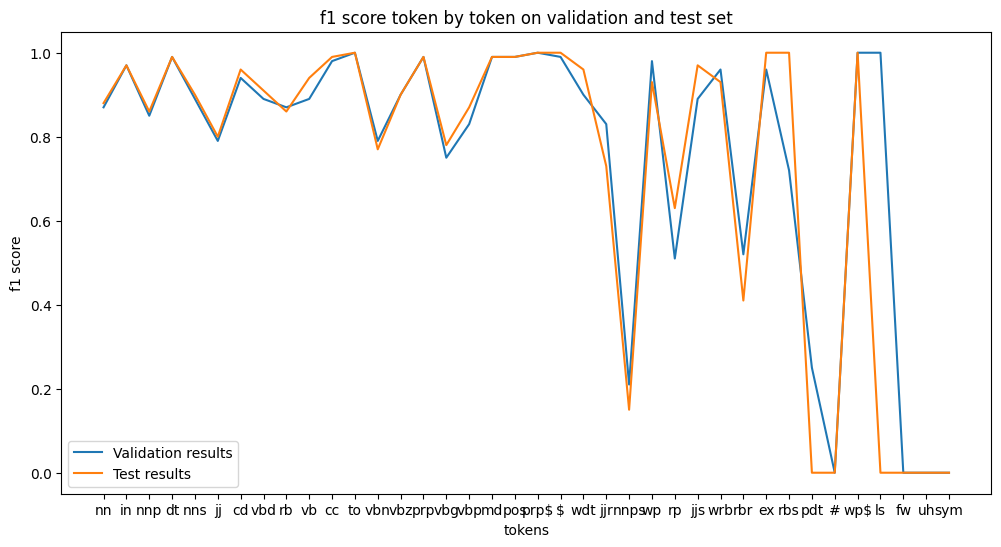

In [74]:
# Plot the results
plot_results(comparison_cm)

25/41 [=================>............] - ETA: 0s

41/41 [==============================] - 1s 17ms/step


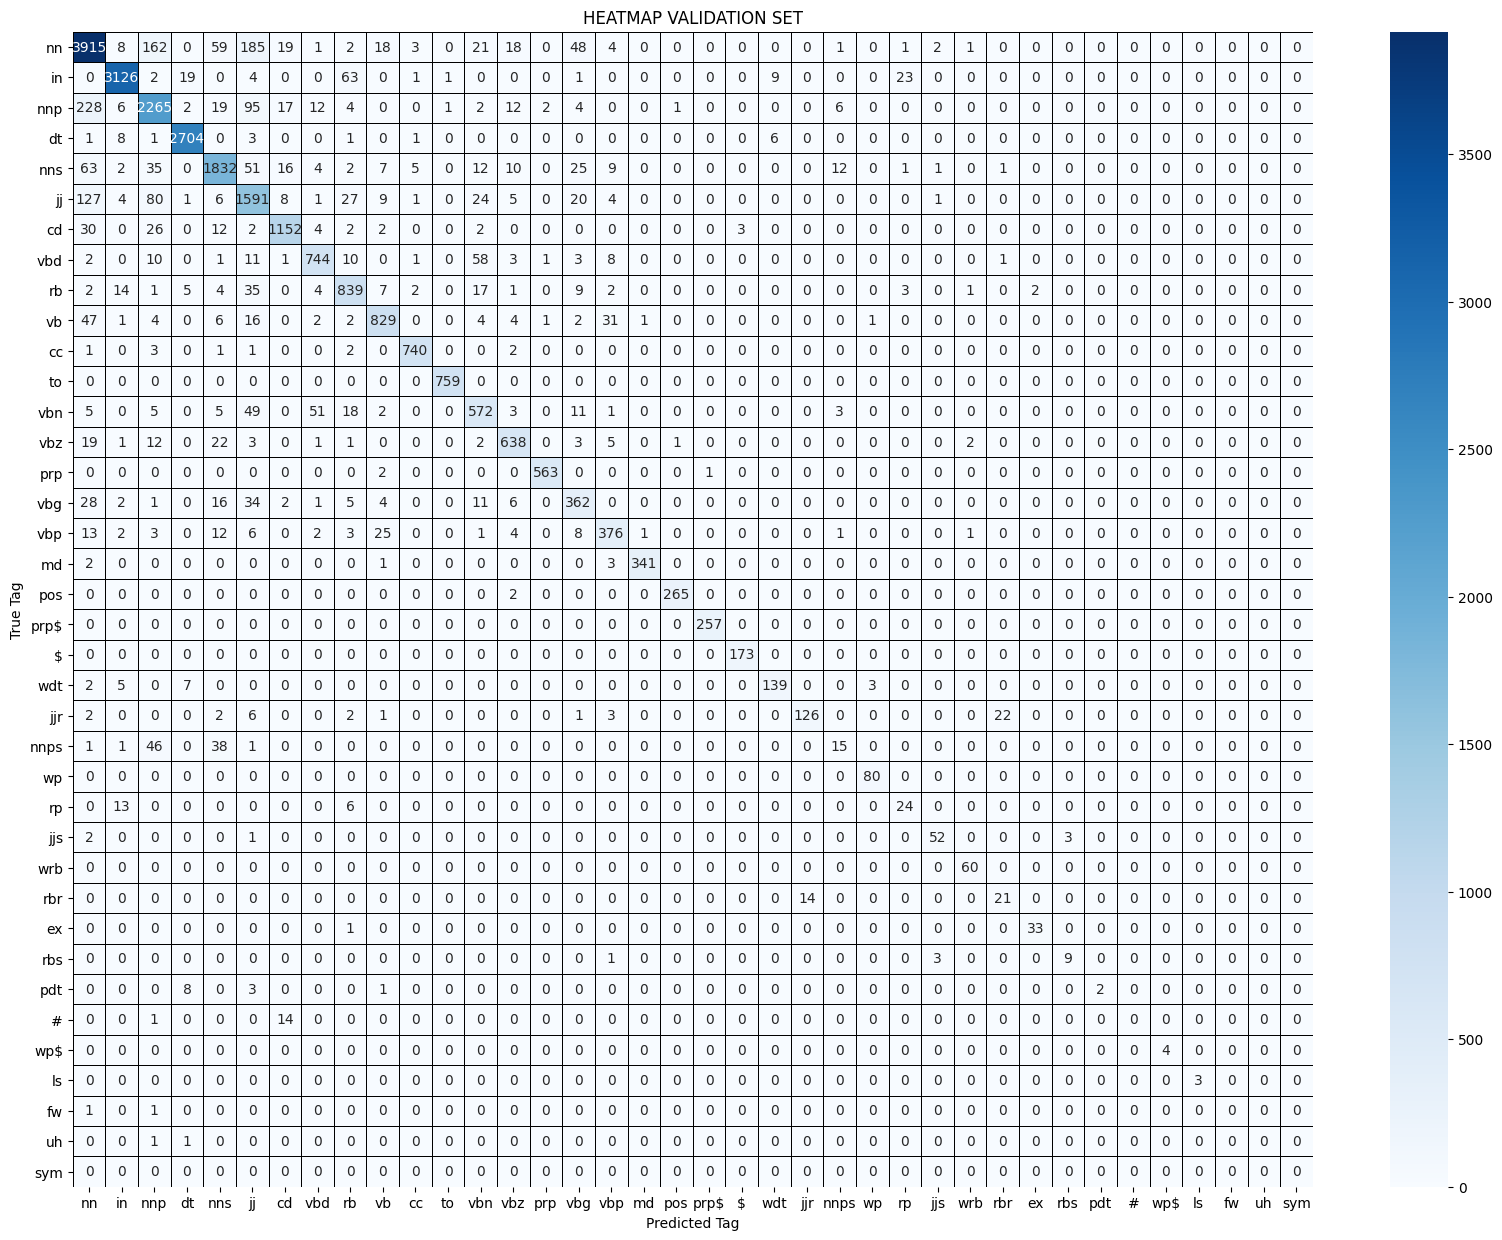

21/21 [==============================] - 0s 17ms/step


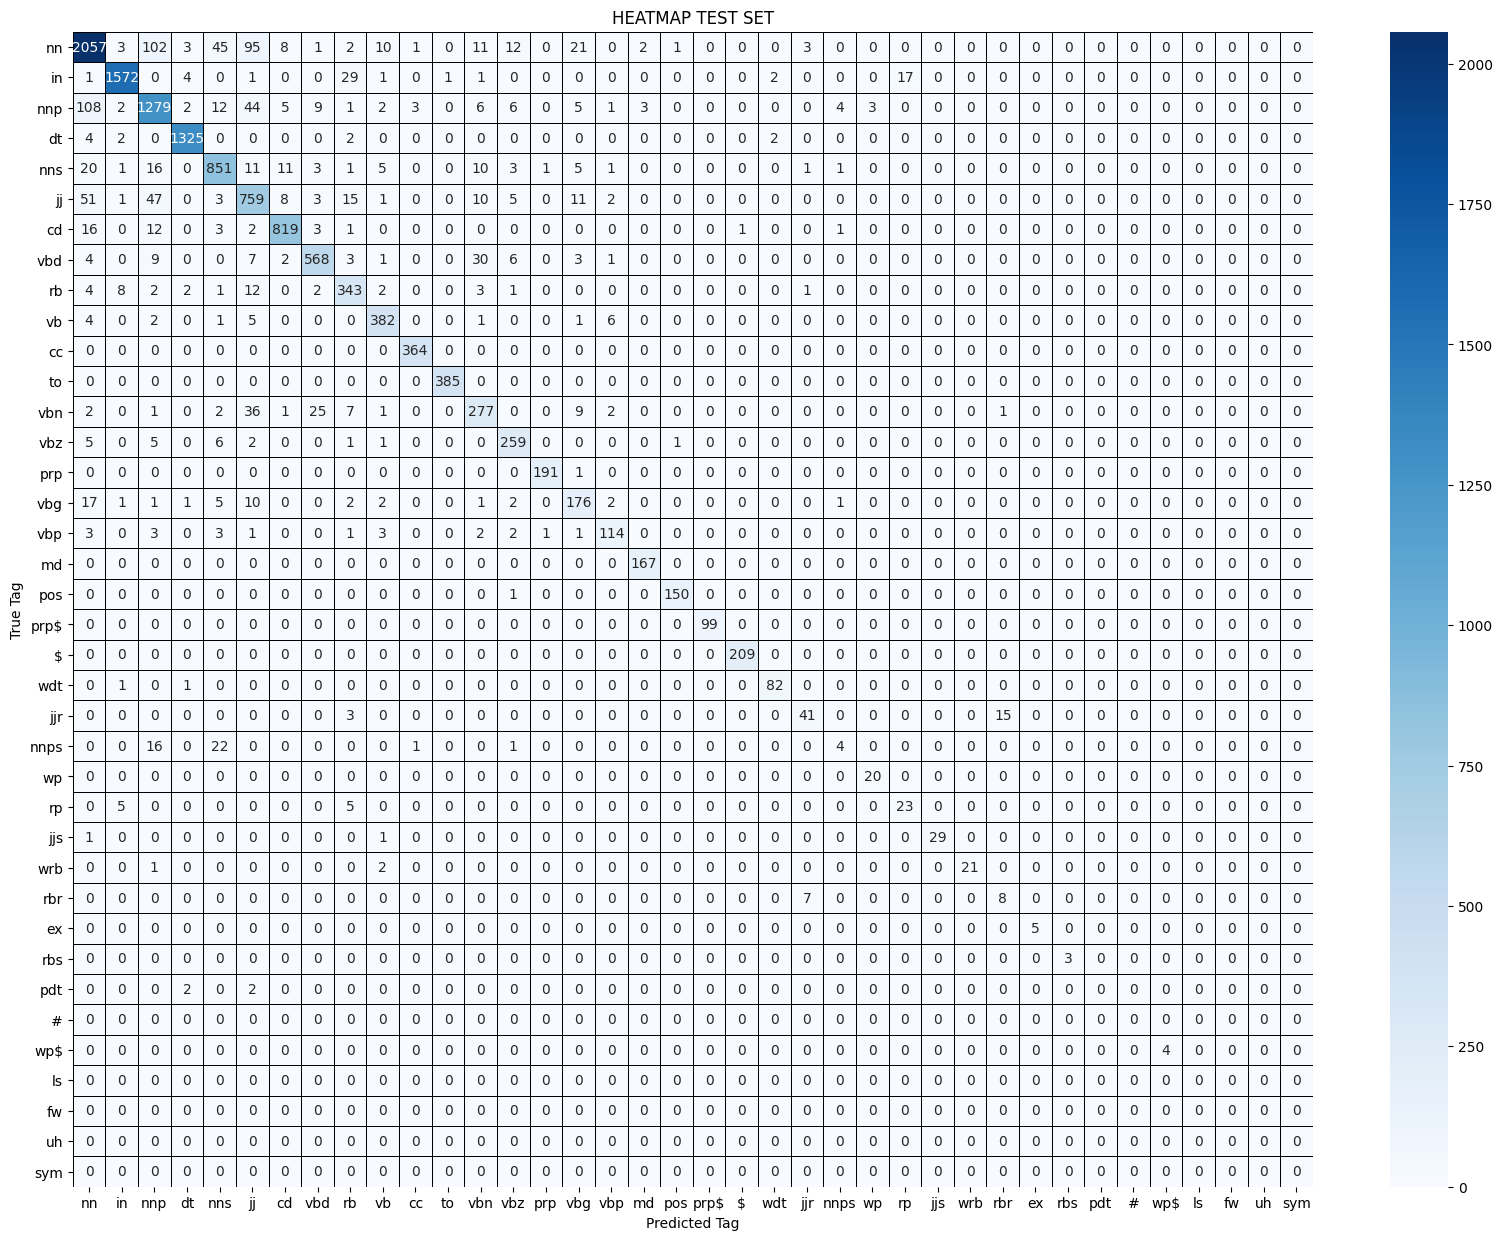

In [75]:
# Observe on detail the errors made by the model on validation and test
heatmap_val = heatmap(best_model, Xval_padded, yval_padded, 'HEATMAP VALIDATION SET')
heatmap_test = heatmap(best_model, Xtest_padded, ytest_padded, 'HEATMAP TEST SET')

<br>
<br>

#### **6.2 Error aggregation**


To go deeper in the error analysis we divided the tags in 10 macro-categories:
 1. **Noun Tags:**
     - 'nn': Noun
     - 'nnp': Proper Noun
     - 'nns': Plural Noun
     - 'nnps': Plural Proper Noun
2. **Determiner Tags:**
     - 'dt': Determiner
3. **Adjective Tags:**
     - 'jj': Adjective
     - 'jjr': Comparative Adjective
     - 'jjs': Superlative Adjective
4. **Verb Tags:**
     - 'vb': Verb
     - 'vbd': Past Tense Verb
     - 'vbn': Past Participle Verb
     - 'vbz': Third Person Singular Present Verb
     - 'vbz': Gerund or Present Participle Verb
     - 'vbp': Non-3rd Person Singular Present Verb
5. **Adverb Tags:**
     - 'rb': Adverb
     - 'rbr': Comparative Adverb
     - 'rbs': Superlative Adverb
6. **Pronoun Tags:**
     - prp: Pronoun
     - prp$: Possessive Pronoun
7. **Preposition and Conjunction Tags:**
     - in: Preposition
     - cc: Conjunction
8. **Modal Tags:**
     - md: Modal
9. **Other Tags:**
     - pos: Possessive Ending
     - rp: Particle
     - uh: Interjection
     - cd: Cardinal Number
     - $: Symbol (Dollar)
     - #: Symbol (Pound)
     - wdt: Wh-determiner
     - wp: Wh-pronoun
     - wp$: Possessive Wh-pronoun
     - wrb: Wh-adverb
     - pdt: Predeterminer
     - ls: List Item Marker
     - fw: Foreign Word
     - ex: Existential There



In [76]:
# Next lines of code are used to generate the confusion matrix category-wise instead of token-wise


nouns = ['nn', 'nnp', 'nns', 'nnps']
determiners = ['dt', 'pdt', 'wdt']
adjectives = ['jj', 'jjr', 'jjs']
verbs = ['vb', 'vbd', 'vbn', 'vbz', 'vbp', 'vbg']
adverbs = ['rb', 'rbr', 'rbs', 'wrb']
pronouns = ['prp', 'prp$', 'wp', 'wp$']
prepositions_and_conjunctions = ['cc', 'in', 'rp', 'to']
others = ['cd', 'ex', 'fw', 'ls', 'md', 'pos', 'sym', 'uh', '$', '#']

def aggregative_matrix(model, X, y, title):
    nouns_tokens = [key for key, value in tag_to_idx.index_word.items() if value in nouns]
    determiners_tokens = [key for key, value in tag_to_idx.index_word.items() if value in determiners]
    adjectives_tokens = [key for key, value in tag_to_idx.index_word.items() if value in adjectives]
    verbs_tokens = [key for key, value in tag_to_idx.index_word.items() if value in verbs]
    adverbs_tokens = [key for key, value in tag_to_idx.index_word.items() if value in adverbs]
    pronouns_tokens = [key for key, value in tag_to_idx.index_word.items() if value in pronouns]
    prepositions_and_conjunctions_tokens = [key for key, value in tag_to_idx.index_word.items() if value in prepositions_and_conjunctions]
    others_tokens = [key for key, value in tag_to_idx.index_word.items() if value in others]
    categories = ['nouns_tokens', 'determiners_tokens', 'adjectives_tokens', 'verbs_tokens', 'adverbs_tokens', 'pronouns_tokens', 'prepositions_and_conjunctions_tokens', 'others_tokens']
    categories_tokens = [1, 2, 3, 4, 5, 6, 7, 8]

    ypred = compute_predictions(model, X)
    ytrue = np.argmax(y, axis=-1).flatten()

    # Convert predictions into predictions on categories
    for i in range(ypred.shape[0]):
        for j in range(ypred.shape[1]):
            if ypred[i, j] in nouns_tokens:
                ypred[i, j] = 1
            elif ypred[i, j] in determiners_tokens:
                ypred[i, j] = 2
            elif ypred[i, j] in adjectives_tokens:
                ypred[i, j] = 3
            elif ypred[i, j] in verbs_tokens:
                ypred[i, j] = 4
            elif ypred[i, j] in adverbs_tokens:
                ypred[i, j] = 5
            elif ypred[i, j] in pronouns_tokens:
                ypred[i, j] = 6
            elif ypred[i, j] in prepositions_and_conjunctions_tokens:
                ypred[i, j] = 7
            elif ypred[i, j] in others_tokens:
                ypred[i, j] = 8
            else:
                ypred[i, j] = 0
        
    # Convert true values into true categories values
    for i in range(ytrue.shape[0]):
        if ytrue[i] in nouns_tokens:
            ytrue[i] = 1
        elif ytrue[i] in determiners_tokens:
            ytrue[i] = 2
        elif ytrue[i] in adjectives_tokens:
            ytrue[i] = 3
        elif ytrue[i] in verbs_tokens:
            ytrue[i] = 4
        elif ytrue[i] in adverbs_tokens:
            ytrue[i] = 5
        elif ytrue[i] in pronouns_tokens:
            ytrue[i] = 6
        elif ytrue[i] in prepositions_and_conjunctions_tokens:
            ytrue[i] = 7
        elif ytrue[i] in others_tokens:
            ytrue[i] = 8
        else:
            ytrue[i] = 0
    
    columns = [str(label) for label in range(len(categories)+1)]
    rows = [str(label) for label in range(len(categories)+1)]
    df = pd.DataFrame(np.zeros((len(categories)+1, len(categories)+1), dtype=int), columns=columns, index=rows)

    for true_label, pred_label in zip(ytrue, ypred.flatten()):
        if true_label != 0 and pred_label != 0:
            df.at[str(true_label), str(pred_label)] += 1

    new_columns = {'1': 'nouns', 
                   '2': 'determiners', 
                   '3': 'adjectives',
                   '4': 'verbs',
                   '5': 'adverbs',
                   '6': 'pronouns',
                   '7': 'prep_and_conj',
                   '8': 'others'}
    df.rename(columns=new_columns, inplace=True)
    new_indices = {'1': 'nouns', 
                   '2': 'determiners', 
                   '3': 'adjectives',
                   '4': 'verbs',
                   '5': 'adverbs',
                   '6': 'pronouns',
                   '7': 'prep_and_conj',
                   '8': 'others'}
    df.rename(index=new_indices, inplace=True)
    df = df.drop(index='0', columns='0')

    plt.figure(figsize=(10, 4))
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.show()
    return df

12/41 [=======>......................] - ETA: 0s

41/41 [==============================] - 1s 15ms/step


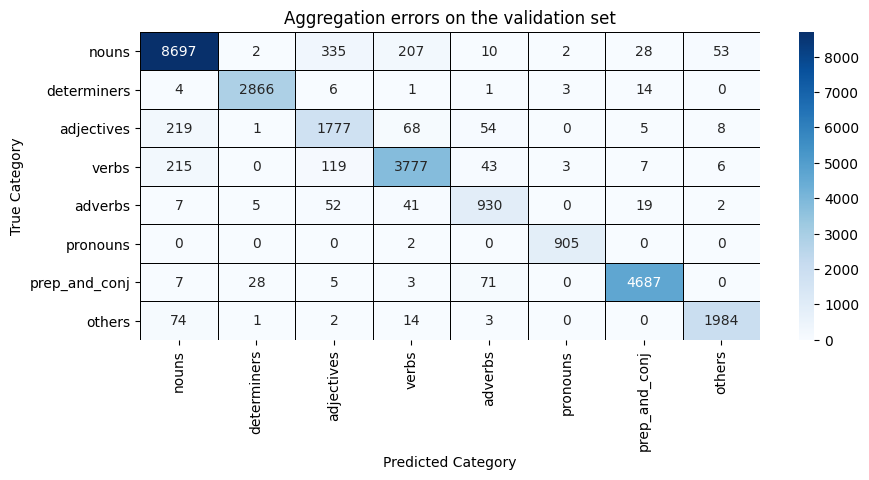

,nouns,determiners,adjectives,verbs,adverbs,pronouns,prep_and_conj,others
nouns,8697,2,335,207,10,2,28,53
determiners,4,2866,6,1,1,3,14,0
adjectives,219,1,1777,68,54,0,5,8
verbs,215,0,119,3777,43,3,7,6
adverbs,7,5,52,41,930,0,19,2
pronouns,0,0,0,2,0,905,0,0
prep_and_conj,7,28,5,3,71,0,4687,0
others,74,1,2,14,3,0,0,1984


In [77]:
# Validation set
aggregative_matrix(best_model, Xval_padded, yval_padded, 'Aggregation errors on the validation set')

<br>
<br>

 4/21 [====>.........................] - ETA: 0s

21/21 [==============================] - 0s 18ms/step


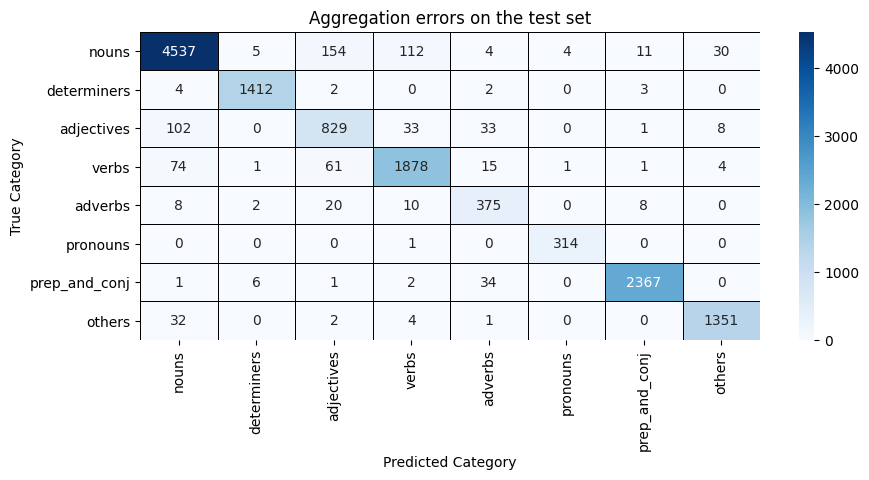

,nouns,determiners,adjectives,verbs,adverbs,pronouns,prep_and_conj,others
nouns,4537,5,154,112,4,4,11,30
determiners,4,1412,2,0,2,0,3,0
adjectives,102,0,829,33,33,0,1,8
verbs,74,1,61,1878,15,1,1,4
adverbs,8,2,20,10,375,0,8,0
pronouns,0,0,0,1,0,314,0,0
prep_and_conj,1,6,1,2,34,0,2367,0
others,32,0,2,4,1,0,0,1351


In [78]:
# Test set
aggregative_matrix(best_model, Xtest_padded, ytest_padded, 'Aggregation errors on the test set')

<br>
<br>

#### **6.3 Comments about the errors and proposals of possible solutions**

Apparently the biggest problem in the selected model is the inability to correctly classify tokens that in particular belongs to the following aggregate categories:

- `adjectives`
- `verbs`
- `nouns`

Specifically, the model is not always able to distinguish between `adjectives` and `nouns`, `verbs` and `nouns` and `adjectives`.

To comprehend the misclassification of these tags, an examination was conducted into their occurrence frequency within the datasets. The training set is heavily imbalanced. In fact, it includes a limited number of `UH` (Interjection) token and a couple of `FW` (Foreign Word) tokens. They're also very few `PDT` (Predeterminer) tokens. This explains the models' poor performance on these tags. While the categories listed above are widely used and the same word is often used with different meanings in other categories as well, for these reasons their classification is not consistently accurate.

For example, in the `nouns` category for the `NNPS` (Proper Plural Noun), the model displays indecision in distinguishing among `NNP` (Plural Noun), `NNS` (Singular Noun), and `NNPS` (Proper Plural Noun).

Moreover, the models cannot distinguish between:
- Comparative/superlative adverbs `RBR`/`RBS` and their respective adjectives `JJR`/`JJS`.

- Predeterminers `PDT` and determiners `DT`.

#### **By integrating these following solutions, the model's performance can be enhanced, leading to more accurate and reliable classifications, particularly in the specified challenging categories.**

1) Balancing the Training Set: Conduct a review of the training set's balance. Increase the representation of underrepresented tags such as UH (Interjection), FW (Foreign Word), and PDT (Predeterminer).

2) Feature Engineering: Explore additional features for example introducing context-aware features or leveraging contextual embeddings.

3) Specialized Training for Underrepresented Tags: Consider training the model with a specific focus on underrepresented tags, providing it with more exposure to instances where it struggles.